In [1]:
import pandas as pd
import numpy as np
import json
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)

In [2]:
shot_metrics_df = pd.read_csv("shot_metric_df.csv")
shot_metrics_df.head()

,Unnamed: 0,event_id,event_index,period,timestamp,minute,second,possession,duration,obv_for_after,obv_for_before,obv_for_net,obv_against_after,obv_against_before,obv_against_net,obv_total_net,under_pressure,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,location_x,location_y,location_z,related_events,player_id,player_name,position_id,position_name,statsbomb_xg,goal,penalty,body_part,opposition_in_triangle,gameId,match_date,Count HI_now,Count HI_half,Count HI_game,Count HSR_now,Count HSR_half,Count HSR_game,Count High Acceleration_now,Count High Acceleration_half,Count High Acceleration_game,Count High Deceleration_now,Count High Deceleration_half,Count High Deceleration_game,Count Medium Acceleration_now,Count Medium Acceleration_half,Count Medium Acceleration_game,Count Medium Deceleration_now,Count Medium Deceleration_half,Count Medium Deceleration_game,Count Sprint_now,Count Sprint_half,Count Sprint_game,High Intensity (HI) Distance_now,High Intensity (HI) Distance_half,High Intensity (HI) Distance_game,High Speed Running (HSR) Distance_now,High Speed Running (HSR) Distance_half,High Speed Running (HSR) Distance_game,M/min_now,M/min_half,M/min_game,Max Speed_now,Max Speed_half,Max Speed_game,Running Distance_now,Running Distance_half,Running Distance_game,Sprinting Distance_now,Sprinting Distance_half,Sprinting Distance_game,Total Distance_now,Total Distance_half,Total Distance_game,Count HI_1_week,Count HSR_1_week,Count High Acceleration_1_week,Count High Deceleration_1_week,Count Medium Acceleration_1_week,Count Medium Deceleration_1_week,Count Sprint_1_week,High Intensity (HI) Distance_1_week,High Speed Running (HSR) Distance_1_week,M/min_1_week,Max Speed_1_week,Running Distance_1_week,Sprinting Distance_1_week,Total Distance_1_week,Count HI_2_week,Count HSR_2_week,Count High Acceleration_2_week,Count High Deceleration_2_week,Count Medium Acceleration_2_week,Count Medium Deceleration_2_week,Count Sprint_2_week,High Intensity (HI) Distance_2_week,High Speed Running (HSR) Distance_2_week,M/min_2_week,Max Speed_2_week,Running Distance_2_week,Sprinting Distance_2_week,Total Distance_2_week,Count HI_1_month,Count HSR_1_month,Count High Acceleration_1_month,Count High Deceleration_1_month,Count Medium Acceleration_1_month,Count Medium Deceleration_1_month,Count Sprint_1_month,High Intensity (HI) Distance_1_month,High Speed Running (HSR) Distance_1_month,M/min_1_month,Max Speed_1_month,Running Distance_1_month,Sprinting Distance_1_month,Total Distance_1_month,birth_date
0,0,24392d1d-314a-4063-a729-7775bc0a2c45,130.0,1.0,00:03:04.524,3.0,4.0,9.0,0.471596,0.306241,0.278243,0.027997,0.007197,0.007197,0.0,0.027997,True,16.0,Shot,36.0,Manchester City,2.0,From Corner,36.0,Manchester City,112.7,39.9,0.22,"67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...",23616.0,Erling Håland,23.0,Center Forward,0.166126,1.0,0.0,Left Foot,1.0,3892755,2023-08-11,1.200000,0.0,0.0,1.000000,0.0,0.0,0.200000,0.0,0.0,0.400000,0.0,0.0,6.800000,0.0,0.0,4.400000,0.0,0.0,0.200000,0.0,0.0,17.017352,0.000000,0.000000,15.196193,0.000000,0.000000,20.433466,0.000000,0.000000,5.187833,0.000000,0.000000,37.352316,0.000000,0.000000,1.821159,0.000000,0.000000,306.501986,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-07-21
1,1,3c527d7b-6932-4190-8424-d1d3dcdd6a4d,191.0,1.0,00:05:11.529,5.0,11.0,11.0,1.023995,0.000000,0.034124,-0.034124,0.009421,0.009421,0.0,-0.034124,NaN,16.0,Shot,36.0,Manchester City,7.0,From Goal Kick,36.0,Manchester City,88.4,46.0,0.00,207b5c5a-ff48-4534-a5e2-0f83b20df80a,3089.0,Kevin De Bruyne,13.0,Right Center Midfield,0.023693,0.0,0.0,Right Foot,2.0,3892755,2023-08-11,4.000000,0.0,0.0,3.666667,0.0,0.0,0.666667,0.0,0.0,1.000000,0.0,0.0,14.000000,0.0,0.0,11.000000,0.0,0.0,0.333333,0.0,0.0,37.031555,0.000000,0.000000,31.198649,0.000000,0.000000,40.1

In [35]:
shot_metrics_df["age"]= (pd.to_datetime(shot_metrics_df["match_date"])-pd.to_datetime(shot_metrics_df["birth_date"]))/pd.Timedelta(days=365.25)
shot_metrics_df["age"]= shot_metrics_df["age"].astype(int)

In [36]:

variable_list = [
    "High Intensity (HI) Distance_now", "High Intensity (HI) Distance_half", "High Intensity (HI) Distance_game", 
    "High Speed Running (HSR) Distance_now", "High Speed Running (HSR) Distance_half", "High Speed Running (HSR) Distance_game", 
    "Running Distance_now", "Running Distance_half", "Running Distance_game", 
    "Sprinting Distance_now", "Sprinting Distance_half", "Sprinting Distance_game", 
    "Total Distance_now", "Total Distance_half", "Total Distance_game", 
    "Count HI_1_week", "Count HSR_1_week", "Count High Acceleration_1_week", "Count High Deceleration_1_week", 
    "Count Medium Acceleration_1_week", "Count Medium Deceleration_1_week", "Count Sprint_1_week", 
    "High Intensity (HI) Distance_1_week", "High Speed Running (HSR) Distance_1_week", "M/min_1_week", 
    "Max Speed_1_week", "Running Distance_1_week", "Sprinting Distance_1_week", "Total Distance_1_week", 
    "Count HI_2_week", "Count HSR_2_week", "Count High Acceleration_2_week", "Count High Deceleration_2_week", 
    "Count Medium Acceleration_2_week", "Count Medium Deceleration_2_week", "Count Sprint_2_week", 
    "High Intensity (HI) Distance_2_week", "High Speed Running (HSR) Distance_2_week", "M/min_2_week", 
    "Max Speed_2_week", "Running Distance_2_week", "Sprinting Distance_2_week", "Total Distance_2_week", 
    "Count HI_1_month", "Count HSR_1_month", "Count High Acceleration_1_month", "Count High Deceleration_1_month", 
    "Count Medium Acceleration_1_month", "Count Medium Deceleration_1_month", "Count Sprint_1_month", 
    "High Intensity (HI) Distance_1_month", "High Speed Running (HSR) Distance_1_month", "M/min_1_month", 
    "Max Speed_1_month", "Running Distance_1_month", "Sprinting Distance_1_month", "Total Distance_1_month"
]


In [37]:
#clean df for ML use
shot_metrics_df =shot_metrics_df[shot_metrics_df.penalty==0]
shot_metrics_df = shot_metrics_df.fillna(0)
shot_metrics_df.under_pressure = np.where(shot_metrics_df.under_pressure==True,1,0)
shot_metrics_df.under_pressure

0        1
1        0
2        0
3        0
4        0
        ..
61649    1
61650    1
61651    0
61652    1
61653    1
Name: under_pressure, Length: 60896, dtype: int64

In [38]:
#leave spanish clubs out
#clubs to leave out of training

test_clubs = [
    "Athletic Club",
    "Getafe",
    "Real Betis",
    "Girona",
  "Las Palmas",
    "Sevilla",
    "Celta Vigo",
   "Deportivo Alavés",
     "Osasuna",
     "Barcelona",
    "Valencia",
     "Rayo Vallecano",
    "Real Sociedad",
     "Real Madrid",
     "Mallorca",
    "Villarreal",
    "Atlético Madrid"
    ]

In [39]:
shot_metrics_df.head(1)

,Unnamed: 0,event_id,event_index,period,timestamp,minute,second,possession,duration,obv_for_after,obv_for_before,obv_for_net,obv_against_after,obv_against_before,obv_against_net,obv_total_net,under_pressure,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,location_x,location_y,location_z,related_events,player_id,player_name,position_id,position_name,statsbomb_xg,goal,penalty,body_part,opposition_in_triangle,gameId,match_date,Count HI_now,Count HI_half,Count HI_game,Count HSR_now,Count HSR_half,Count HSR_game,Count High Acceleration_now,Count High Acceleration_half,Count High Acceleration_game,Count High Deceleration_now,Count High Deceleration_half,Count High Deceleration_game,Count Medium Acceleration_now,Count Medium Acceleration_half,Count Medium Acceleration_game,Count Medium Deceleration_now,Count Medium Deceleration_half,Count Medium Deceleration_game,Count Sprint_now,Count Sprint_half,Count Sprint_game,High Intensity (HI) Distance_now,High Intensity (HI) Distance_half,High Intensity (HI) Distance_game,High Speed Running (HSR) Distance_now,High Speed Running (HSR) Distance_half,High Speed Running (HSR) Distance_game,M/min_now,M/min_half,M/min_game,Max Speed_now,Max Speed_half,Max Speed_game,Running Distance_now,Running Distance_half,Running Distance_game,Sprinting Distance_now,Sprinting Distance_half,Sprinting Distance_game,Total Distance_now,Total Distance_half,Total Distance_game,Count HI_1_week,Count HSR_1_week,Count High Acceleration_1_week,Count High Deceleration_1_week,Count Medium Acceleration_1_week,Count Medium Deceleration_1_week,Count Sprint_1_week,High Intensity (HI) Distance_1_week,High Speed Running (HSR) Distance_1_week,M/min_1_week,Max Speed_1_week,Running Distance_1_week,Sprinting Distance_1_week,Total Distance_1_week,Count HI_2_week,Count HSR_2_week,Count High Acceleration_2_week,Count High Deceleration_2_week,Count Medium Acceleration_2_week,Count Medium Deceleration_2_week,Count Sprint_2_week,High Intensity (HI) Distance_2_week,High Speed Running (HSR) Distance_2_week,M/min_2_week,Max Speed_2_week,Running Distance_2_week,Sprinting Distance_2_week,Total Distance_2_week,Count HI_1_month,Count HSR_1_month,Count High Acceleration_1_month,Count High Deceleration_1_month,Count Medium Acceleration_1_month,Count Medium Deceleration_1_month,Count Sprint_1_month,High Intensity (HI) Distance_1_month,High Speed Running (HSR) Distance_1_month,M/min_1_month,Max Speed_1_month,Running Distance_1_month,Sprinting Distance_1_month,Total Distance_1_month,birth_date,age,WI_now,WI_half,WI_game,WI_1_week,WI_2_week,WI_1_month,ACWR
0,0,24392d1d-314a-4063-a729-7775bc0a2c45,130.0,1.0,00:03:04.524,3.0,4.0,9.0,0.471596,0.306241,0.278243,0.027997,0.007197,0.007197,0.0,0.027997,1,16.0,Shot,36.0,Manchester City,2.0,From Corner,36.0,Manchester City,112.7,39.9,0.22,"67dc6041-d315-4ebb-ac8e-18f3fcd24abc, 7d4f2f91...",23616.0,Erling Håland,23.0,Center Forward,0.166126,1.0,0.0,Left Foot,1.0,3892755,2023-08-11,1.2,0.0,0.0,1.0,0.0,0.0,0.2,0.0,0.0,0.4,0.0,0.0,6.8,0.0,0.0,4.4,0.0,0.0,0.2,0.0,0.0,17.017352,0.0,0.0,15.196193,0.0,0.0,20.433466,0.0,0.0,5.187833,0.0,0.0,37.352316,0.0,0.0,1.821159,0.0,0.0,306.501986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000-07-21,23,343.837849,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
ML_data= shot_metrics_df[["team_name","goal", "under_pressure","play_pattern_name","body_part" ,"location_x","location_y","location_z","opposition_in_triangle"]]
play_pattern_onehot = pd.get_dummies(ML_data.play_pattern_name, 
    prefix="play_pattern")#, dtype=float)
body_part_onehot = pd.get_dummies(ML_data.body_part, 
    prefix="pbody_part")#, dtype=float)
ML_data = pd.concat([ML_data,play_pattern_onehot,body_part_onehot], axis=1).drop(["play_pattern_name","body_part"],axis=1)
training_data =  ML_data[~ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)
test_data =  ML_data[ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)

In [41]:
X_train_raw = training_data.drop("goal", axis=1).astype(float)
y_train_raw = training_data["goal"].astype(int)

X_test = np.array(test_data.drop("goal", axis=1).astype(float))
y_test = np.array(test_data["goal"].astype(int))

#scaler = StandardScaler()
#model = scaler.fit(X_train_raw)
#X_scaled = model.transform(X_train_raw)
#X_test = model.transform(X_test_raw)
X_train, X_val, y_train, y_val = train_test_split(
    np.array(X_train_raw), np.array(y_train_raw), test_size=0.25, random_state=123
)

In [42]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(X_train_res.shape, y_train_res.shape)  # balanced now

(69330, 18) (69330,)


In [43]:
np.bincount(y_train_res)

array([34665, 34665])

In [44]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score


# Define features and target
neg, pos = np.bincount(y_train)
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")


# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=1000,       # number of trees
    max_depth=5,           # depth of each tree
    learning_rate=0.05,     # step size shrinkage
    subsample=0.8,        # row sampling
    colsample_bytree=0.8,  # feature sampling
    random_state=42,
    use_label_encoder=False,
    objective="binary:logistic",#logitraw
    eval_metric="logloss",
    #scale_pos_weight=4  # avoids warning about label encoder
)

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Evaluation
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

scale_pos_weight = 8.43


c:\Users\conny\OneDrive\Documents\Projects\Hudl_Performance\Hudl_Performance_Insights_2025\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:18:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.904
ROC AUC: 0.757


In [45]:
statsbomb_test = np.where(shot_metrics_df[shot_metrics_df.team_name.isin(test_clubs)].statsbomb_xg>0.5,1,0)
statsbomb_actual = np.array(shot_metrics_df[shot_metrics_df.team_name.isin(test_clubs)].goal)
statsbomb_proba = np.array(shot_metrics_df[shot_metrics_df.team_name.isin(test_clubs)].statsbomb_xg)

In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[8178,   83],
       [ 799,  131]])

In [47]:
confusion_matrix(statsbomb_actual,statsbomb_test )

array([[8206,   55],
       [ 794,  136]])

In [48]:
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

Accuracy: 0.904
ROC AUC: 0.757


In [49]:
acc = accuracy_score(statsbomb_actual,statsbomb_test )
roc = roc_auc_score(statsbomb_actual, statsbomb_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

Accuracy: 0.908
ROC AUC: 0.793


In [50]:
training_data.columns

Index(['goal', 'under_pressure', 'location_x', 'location_y', 'location_z',
       'opposition_in_triangle', 'play_pattern_From Corner',
       'play_pattern_From Counter', 'play_pattern_From Free Kick',
       'play_pattern_From Goal Kick', 'play_pattern_From Keeper',
       'play_pattern_From Kick Off', 'play_pattern_From Throw In',
       'play_pattern_Other', 'play_pattern_Regular Play', 'pbody_part_Head',
       'pbody_part_Left Foot', 'pbody_part_Other', 'pbody_part_Right Foot'],
      dtype='object')

from autogluon.tabular import TabularPredictor
import numpy as np

# Compute class weights
neg, pos = np.bincount(y_train)
scale = neg / pos

# Assign weights: higher weight for goals (minority class)
weights = np.where(y_train == 1, scale, 1.0)

# Add weights column to training data
train_with_weights = X_train.copy()
#train_with_weights["weight"] = weights

# Fit AutoGluon with weights
predictor = TabularPredictor(
    label="goal",
    eval_metric="roc_auc",#""       # better than accuracy for imbalanced classes
    problem_type="binary"
).fit(
    training_data,
    #sample_weight="weight",
    presets="best_quality",
    time_limit=900
)

autogluon roc_auc 15 minutes
Accuracy: 0.906
ROC AUC: 0.777

from autogluon.tabular import TabularPredictor
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming predictor is already trained:
# predictor = TabularPredictor(...).fit(...)

# Get predictions (hard labels) and predicted probabilities
y_pred = predictor.predict(test_data)
y_pred_proba = predictor.predict_proba(test_data)[1]  # probability for class=1

# True labels
y_true = test_data["goal"]

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.3f}")

# ROC AUC
roc = roc_auc_score(y_true, y_pred_proba)
print(f"ROC AUC: {roc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor.class_labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


# Assuming you already trained:
# predictor = TabularPredictor(...).fit(...)

import matplotlib.pyplot as plt

fi = predictor.feature_importance(test_data)  # or training_data

# fi is a DataFrame with importance values
print(fi.head())

# Plot feature importance
fi.plot(kind="barh", figsize=(8, 10))
plt.title("Feature Importance")
plt.show()


In [51]:
importance = model.get_booster().get_score(importance_type="weight")
print(importance)

{'f0': 805.0, 'f1': 7572.0, 'f2': 7117.0, 'f3': 3736.0, 'f4': 1670.0, 'f5': 492.0, 'f6': 247.0, 'f7': 487.0, 'f8': 249.0, 'f9': 193.0, 'f10': 112.0, 'f11': 470.0, 'f12': 81.0, 'f13': 621.0, 'f14': 129.0, 'f15': 594.0, 'f16': 59.0, 'f17': 337.0}


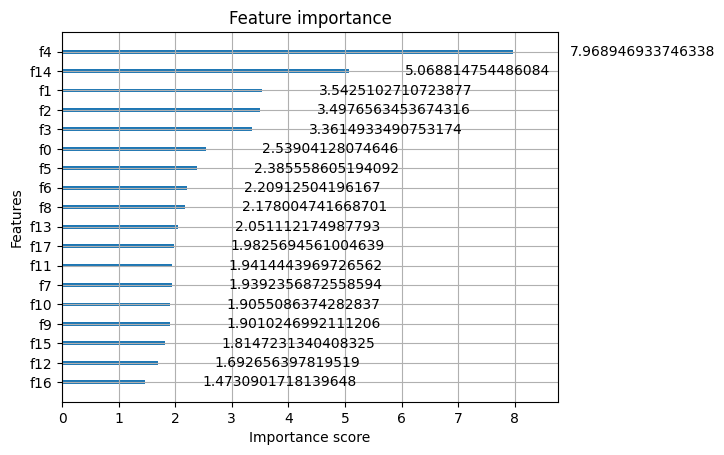

In [52]:
xgb.plot_importance(model, importance_type="gain", max_num_features=20)
plt.show()

In [53]:
training_data.columns

Index(['goal', 'under_pressure', 'location_x', 'location_y', 'location_z',
       'opposition_in_triangle', 'play_pattern_From Corner',
       'play_pattern_From Counter', 'play_pattern_From Free Kick',
       'play_pattern_From Goal Kick', 'play_pattern_From Keeper',
       'play_pattern_From Kick Off', 'play_pattern_From Throw In',
       'play_pattern_Other', 'play_pattern_Regular Play', 'pbody_part_Head',
       'pbody_part_Left Foot', 'pbody_part_Other', 'pbody_part_Right Foot'],
      dtype='object')

In [54]:
importance_df = pd.DataFrame.from_dict(
    model.get_booster().get_score(importance_type="gain"),
    orient="index",
    columns=["importance"]
).sort_values("importance", ascending=False)

print(importance_df.head(10))

     importance
f4     7.968947
f14    5.068815
f1     3.542510
f2     3.497656
f3     3.361493
f0     2.539041
f5     2.385559
f6     2.209125
f8     2.178005
f13    2.051112


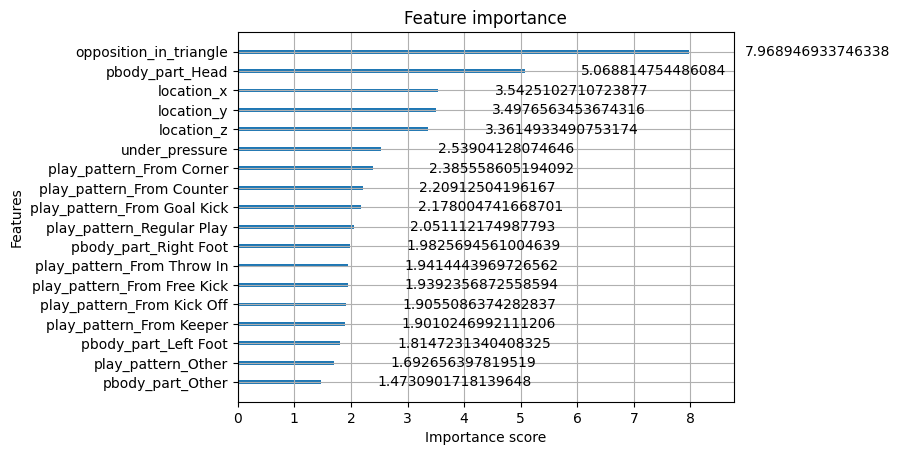

In [55]:
booster = model.get_booster()
booster.feature_names = X_train_raw.columns.tolist()

xgb.plot_importance(booster, importance_type="gain")
plt.show()


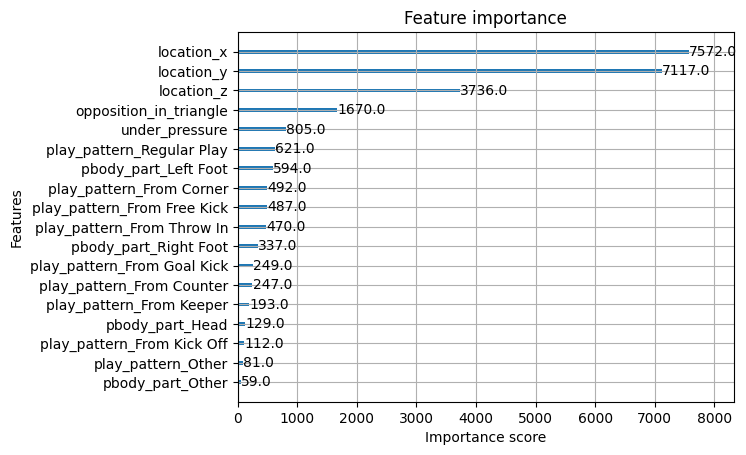

In [56]:
booster = model.get_booster()
booster.feature_names = X_train_raw.columns.tolist()

xgb.plot_importance(booster, importance_type="weight")
plt.show()


add physical metrics

In [57]:
def workload_index(df, period):
    return (
        df[f"Total Distance_{period}"] +
        2 * df[f"High Speed Running (HSR) Distance_{period}"] +
        3 * df[f"Sprinting Distance_{period}"] +
        0.5 * (df[f"Count HI_{period}"] + df[f"Count HSR_{period}"]) +
        1.0 * df[f"Count Sprint_{period}"] +
        0.3 * (df[f"Count High Acceleration_{period}"] + df[f"Count High Deceleration_{period}"])
    )

# Example: compute workload index for different periods
for period in ["now", "half", "game", "1_week", "2_week", "1_month"]:
    shot_metrics_df[f"WI_{period}"] = workload_index(shot_metrics_df, period)

# Compute ACWR (Acute:Chronic Workload Ratio)
shot_metrics_df["ACWR"] = shot_metrics_df["WI_1_week"] / shot_metrics_df["WI_1_month"]

In [58]:
shot_metrics_df.columns

Index(['Unnamed: 0', 'event_id', 'event_index', 'period', 'timestamp',
       'minute', 'second', 'possession', 'duration', 'obv_for_after',
       ...
       'Total Distance_1_month', 'birth_date', 'age', 'WI_now', 'WI_half',
       'WI_game', 'WI_1_week', 'WI_2_week', 'WI_1_month', 'ACWR'],
      dtype='object', length=133)

In [67]:
ML_data= shot_metrics_df[["age","team_name","goal", "under_pressure","play_pattern_name","body_part" ,"location_x","location_y","location_z","opposition_in_triangle",
    'WI_now', 'WI_half', 'WI_game', 'WI_1_week',
       'WI_2_week', 'WI_1_month', 'ACWR'

]]
play_pattern_onehot = pd.get_dummies(ML_data.play_pattern_name, 
    prefix="play_pattern")#, dtype=float)
body_part_onehot = pd.get_dummies(ML_data.body_part, 
    prefix="pbody_part")#, dtype=float)
ML_data = pd.concat([ML_data,play_pattern_onehot,body_part_onehot], axis=1).drop(["play_pattern_name","body_part"],axis=1)
training_data =  ML_data[~ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)
test_data =  ML_data[ML_data.team_name.isin(test_clubs)].drop("team_name",axis=1)

In [68]:
X_train_raw = training_data.drop("goal", axis=1).astype(float)
y_train_raw = training_data["goal"].astype(int)

X_test = np.array(test_data.drop("goal", axis=1).astype(float))
y_test = np.array(test_data["goal"].astype(int))

#scaler = StandardScaler()
#model = scaler.fit(X_train_raw)
#X_scaled = model.transform(X_train_raw)
#X_test = model.transform(X_test_raw)
X_train, X_val, y_train, y_val = train_test_split(
    np.array(X_train_raw), np.array(y_train_raw), test_size=0.25, random_state=123
)

In [69]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score


# Define features and target
neg, pos = np.bincount(y_train)
scale = neg / pos
print(f"scale_pos_weight = {scale:.2f}")


# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=1000,       # number of trees
    max_depth=5,           # depth of each tree
    learning_rate=0.05,     # step size shrinkage
    subsample=0.8,        # row sampling
    colsample_bytree=0.8,  # feature sampling
    random_state=42,
    use_label_encoder=False,
    objective="binary:logistic",
    eval_metric="logloss",
    #scale_pos_weight=4  # avoids warning about label encoder
)

# Train model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

# Evaluation
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {roc:.3f}")

scale_pos_weight = 8.43


c:\Users\conny\OneDrive\Documents\Projects\Hudl_Performance\Hudl_Performance_Insights_2025\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:20:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.904
ROC AUC: 0.759


In [70]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[8173,   88],
       [ 793,  137]])

In [71]:
confusion_matrix(statsbomb_actual,statsbomb_test )

array([[8206,   55],
       [ 794,  136]])

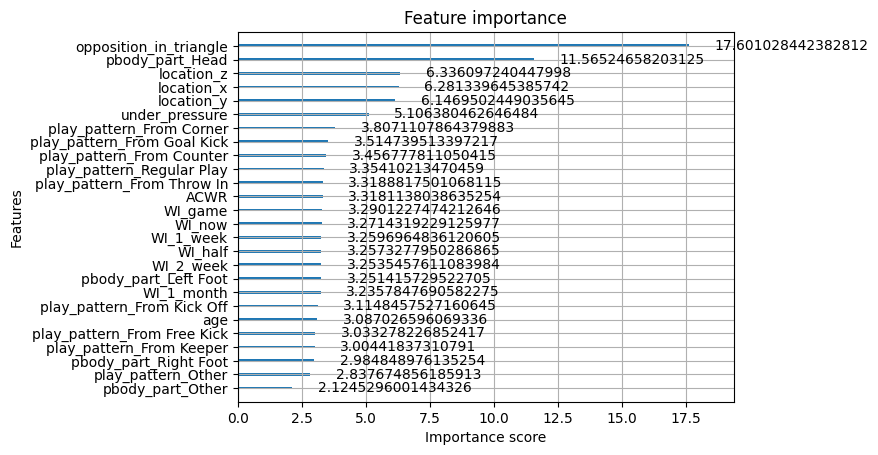

In [72]:
booster = model.get_booster()
booster.feature_names = X_train_raw.columns.tolist()

xgb.plot_importance(booster, importance_type="gain")
plt.show()

In [73]:
importance_df = pd.DataFrame.from_dict(
    model.get_booster().get_score(importance_type="gain"),
    orient="index",
    columns=["importance"]
).sort_values("importance", ascending=False)

print(importance_df.head(30))

                             importance
opposition_in_triangle        17.601028
pbody_part_Head               11.565247
location_z                     6.336097
location_x                     6.281340
location_y                     6.146950
under_pressure                 5.106380
play_pattern_From Corner       3.807111
play_pattern_From Goal Kick    3.514740
play_pattern_From Counter      3.456778
play_pattern_Regular Play      3.354102
play_pattern_From Throw In     3.318882
ACWR                           3.318114
WI_game                        3.290123
WI_now                         3.271432
WI_1_week                      3.259696
WI_half                        3.257328
WI_2_week                      3.253546
pbody_part_Left Foot           3.251416
WI_1_month                     3.235785
play_pattern_From Kick Off     3.114846
age                            3.087027
play_pattern_From Free Kick    3.033278
play_pattern_From Keeper       3.004418
pbody_part_Right Foot          2.984849


from autogluon.tabular import TabularPredictor
import numpy as np

# Compute class weights
neg, pos = np.bincount(y_train)
scale = neg / pos

# Assign weights: higher weight for goals (minority class)
weights = np.where(y_train == 1, scale, 1.0)

# Add weights column to training data
train_with_weights = X_train.copy()
#train_with_weights["weight"] = weights

# Fit AutoGluon with weights
predictor = TabularPredictor(
    label="goal",
    eval_metric="roc_auc",#""       # better than accuracy for imbalanced classes
    problem_type="binary"
).fit(
    training_data,
    #sample_weight="weight",
    presets="best_quality",
    time_limit=900)

In [74]:
from autogluon.tabular import TabularPredictor
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming predictor is already trained:
# predictor = TabularPredictor(...).fit(...)

# Get predictions (hard labels) and predicted probabilities
y_pred = predictor.predict(test_data)
y_pred_proba = predictor.predict_proba(test_data)[1]  # probability for class=1

# True labels
y_true = test_data["goal"]

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.3f}")

# ROC AUC
roc = roc_auc_score(y_true, y_pred_proba)
print(f"ROC AUC: {roc:.3f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor.class_labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


NameError: name 'predictor' is not defined

In [ ]:

import matplotlib.pyplot as plt

fi = predictor.feature_importance(test_data)  # or training_data

# fi is a DataFrame with importance values
print(fi.head())

# Plot feature importance
fi.plot(kind="barh", figsize=(8, 10))
plt.title("Feature Importance")
plt.show()


Computing feature importance via permutation shuffling for 25 features using 5000 rows with 5 shuffle sets...
	1348.92s	= Expected runtime (269.78s per shuffle set)


In [ ]:
print(fi.head(20))

                                      importance    stddev   p_value  n  \
location_x                              0.123722  0.012496  0.000012  5   
location_y                              0.108891  0.008371  0.000004  5   
location_z                              0.054088  0.005666  0.000014  5   
opposition_in_triangle                  0.043519  0.003882  0.000008  5   
under_pressure                          0.006334  0.001807  0.000715  5   
play_pattern_From Corner                0.001894  0.001219  0.012749  5   
pbody_part_Head                         0.001408  0.000581  0.002806  5   
pbody_part_Left Foot                    0.001284  0.000911  0.017203  5   
High Intensity (HI) Distance_1_month    0.000734  0.000329  0.003764  5   
play_pattern_Regular Play               0.000729  0.000694  0.039319  5   
High Intensity (HI) Distance_1_week     0.000528  0.000385  0.018822  5   
High Intensity (HI) Distance_game       0.000485  0.000308  0.012160  5   
play_pattern_From Free Ki